In [1]:
import os
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset_path = 'archive\plantvillage-dataset\color'

tomato_directories = []

# Walk through the dataset path
for root, dirs, files in os.walk(dataset_path):
    for dir_name in dirs:
        # Check if 'Apple' is in the directory name
        if 'Apple' in dir_name:
            tomato_directories.append(os.path.join(root, dir_name))

# Print the apple directories
for directory in tomato_directories:
    print(directory)

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\Yuvra\AppData\Local\Temp\ipykernel_17272\37807443.py:1: SyntaxWarning: invalid escape sequence '\p'
  dataset_path = 'archive\plantvillage-dataset\color'


archive\plantvillage-dataset\color\Apple___Apple_scab
archive\plantvillage-dataset\color\Apple___Black_rot
archive\plantvillage-dataset\color\Apple___Cedar_apple_rust
archive\plantvillage-dataset\color\Apple___healthy


In [4]:
image_paths = []
labels = []

In [5]:
label_mapping = {
    "Apple___healthy": 0,
    "Apple___Apple_scab": 1,
    "Apple___Black_rot": 2,
    "Apple___Cedar_apple_rust": 3,
}

# Iterate through all the tomato directories
for directory in tomato_directories:
    # Get the label based on the directory name
    dir_name = os.path.basename(directory)  # Get the last part of the path
    label = label_mapping.get(dir_name, None)  # Get the corresponding label

    if label is not None:  # Proceed only if the label exists
        # Get all image files in the directory
        file_count = 0
        for file in os.listdir(directory):
            if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                image_paths.append(os.path.join(directory, file))
                labels.append(str(label))  # Append the label
                file_count += 1
        print(f"Directory: {directory}, Added {file_count} files.")
    else:
        print(f"Warning: No label found for directory {dir_name}")

print(f"Total images processed: {len(image_paths)}")

Directory: archive\plantvillage-dataset\color\Apple___Apple_scab, Added 630 files.
Directory: archive\plantvillage-dataset\color\Apple___Black_rot, Added 621 files.
Directory: archive\plantvillage-dataset\color\Apple___Cedar_apple_rust, Added 275 files.
Directory: archive\plantvillage-dataset\color\Apple___healthy, Added 1645 files.
Total images processed: 3171


In [6]:
df = pd.DataFrame({
    'image_path': image_paths,
    'label': labels
})

df.head(5)

,image_path,label
0,archive\plantvillage-dataset\color\Apple___App...,1
1,archive\plantvillage-dataset\color\Apple___App...,1
2,archive\plantvillage-dataset\color\Apple___App...,1
3,archive\plantvillage-dataset\color\Apple___App...,1
4,archive\plantvillage-dataset\color\Apple___App...,1


In [7]:
print(df['label'].value_counts())  # Counts the number of images for each label

label
0    1645
1     630
2     621
3     275
Name: count, dtype: int64


In [8]:
X = df['image_path']  # Your feature (image paths)
y = df['label']

In [9]:
from sklearn.model_selection import train_test_split

# First, split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Then split the training+validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, stratify=y_train_val, random_state=42
)


# Create DataFrames for each split
df_train = pd.DataFrame({'image_path': X_train, 'label': y_train})
df_val = pd.DataFrame({'image_path': X_val, 'label': y_val})
df_test = pd.DataFrame({'image_path': X_test, 'label': y_test})

# Print the sample counts
print(f"Training samples: {len(df_train)}, Validation samples: {len(df_val)}, Test samples: {len(df_test)}")

Training samples: 2028, Validation samples: 508, Test samples: 635


In [11]:
from imblearn.over_sampling import RandomOverSampler  # For oversampling

# Oversampling to handle class imbalance in training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(np.array(X_train).reshape(-1, 1), y_train)

# Create a new DataFrame with resampled data
df_train_resampled = pd.DataFrame({
    'image_path': X_train_resampled.flatten(),
    'label': y_train_resampled
})

In [12]:
train_class_distribution = y_train.value_counts()
resampled_train_class_distribution = y_train_resampled.value_counts()
val_class_distribution = y_val.value_counts()
test_class_distribution = y_test.value_counts()

print("Training Class Distribution:\n", train_class_distribution)
print("Resampled Training Class Distribution:\n", resampled_train_class_distribution)
print("\nValidation Class Distribution:\n", val_class_distribution)
print("\nTest Class Distribution:\n", test_class_distribution)

Training Class Distribution:
 label
0    1052
1     403
2     397
3     176
Name: count, dtype: int64
Resampled Training Class Distribution:
 label
0    1052
1    1052
2    1052
3    1052
Name: count, dtype: int64

Validation Class Distribution:
 label
0    263
1    101
2    100
3     44
Name: count, dtype: int64

Test Class Distribution:
 label
0    330
1    126
2    124
3     55
Name: count, dtype: int64


In [13]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights for the training set
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Data Augmentation with added options
data_augmentation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.3,  # Increased width shift
    height_shift_range=0.3,  # Increased height shift
    brightness_range=[0.8, 1.2],  # Brightness augmentation
    zoom_range=0.2,  # Added zoom
    horizontal_flip=True,
    fill_mode='nearest'
)

# Generators
train_generator = data_augmentation.flow_from_dataframe(
    dataframe=df_train_resampled,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,  # Increased batch size
    class_mode='sparse'
)

val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_dataframe(
    dataframe=df_val,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    x_col='image_path',
    y_col='label',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',
    shuffle=False
)

Found 4208 validated image filenames belonging to 4 classes.
Found 508 validated image filenames belonging to 4 classes.
Found 635 validated image filenames belonging to 4 classes.


In [15]:
from tensorflow.keras.applications import ResNet50, InceptionV3, EfficientNetB0
from tensorflow.keras.layers import Input, Concatenate, Dense, GlobalAveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

# Load pre-trained ResNet50
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_base.trainable = False  # Freeze ResNet50 layers

# Load pre-trained InceptionV3
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
inception_base.trainable = False  # Freeze InceptionV3 layers

# Load pre-trained EfficientNetB0
efficientnet_base = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
efficientnet_base.trainable = False  # Freeze EfficientNetB0 layers

# Define the input
input_layer = Input(shape=(224, 224, 3))

# Extract features from ResNet50, InceptionV3, and EfficientNetB0
resnet_features = resnet_base(input_layer)
resnet_features = MaxPooling2D(pool_size=(2, 2))(resnet_features)  # Apply MaxPooling
resnet_features = GlobalMaxPooling2D()(resnet_features)

inception_features = inception_base(input_layer)
inception_features = MaxPooling2D(pool_size=(2, 2))(inception_features)  # Apply MaxPooling
inception_features = GlobalMaxPooling2D()(inception_features)

efficientnet_features = efficientnet_base(input_layer)
efficientnet_features = MaxPooling2D(pool_size=(2, 2))(efficientnet_features)  # Apply MaxPooling
efficientnet_features = GlobalMaxPooling2D()(efficientnet_features)

# Concatenate the features
combined_features = Concatenate()([resnet_features, inception_features, efficientnet_features])

# Add a fully connected layer
fc_layer = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(combined_features)  # Increase size of FC layer
dropout_layer = Dropout(0.5)(fc_layer)  # Dropout for regularization

# Output layer
output_layer = Dense(len(np.unique(y_train_resampled)), activation='softmax')(dropout_layer)

# Build the model
ensemble_model = Model(inputs=input_layer, outputs=output_layer)

# Unfreeze more layers of ResNet50, InceptionV3, and EfficientNetB0
for layer in resnet_base.layers[-20:]:
    layer.trainable = True

for layer in inception_base.layers[-20:]:
    layer.trainable = True

for layer in efficientnet_base.layers[-20:]:
    layer.trainable = True

# Compile the model with class weights
fine_tune_learning_rate = 1e-5  # Lower learning rate for fine-tuning
ensemble_model.compile(optimizer=Adam(learning_rate=fine_tune_learning_rate),
                       loss='sparse_categorical_crossentropy',
                       metrics=['accuracy'])

ensemble_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ input_layer_3[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ inception_v3        │ (None, 5, 5,      │ 21,802,784 │ input_layer_3[0]… │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetb0      │ (None, 7, 7,      │  4,049,571 │ input_layer_3[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 3, 3,      │          0 │ resnet50[0][0]    │
│ (MaxPooling2D)      │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 2, 2,      │          0 │ inception_v3[0][… │
│ (MaxPooling2D)      │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 3, 3,      │          0 │ efficientnetb0[0… │
│ (MaxPooling2D)      │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ max_pooling2d_4[… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 2048)      │          0 │ max_pooling2d_5[… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 1280)      │          0 │ max_pooling2d_6[… │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 5376)      │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_max_pooli… │
│                     │                   │            │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 512)       │  2,753,024 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 512)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 4)         │      2,052 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 52,195,143 (199.11 MB)

 Trainable params: 14,972,724 (57.12 MB)

 Non-trainable params: 37,222,419 (141.99 MB)

In [16]:
checkpoint_loss = ModelCheckpoint('best_model_loss.keras', monitor='val_loss', save_best_only=True, verbose=1)
checkpoint_accuracy = ModelCheckpoint('best_model_accuracy.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, verbose=1)

# Train the model
history_fine_tune = ensemble_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Train for a larger number of epochs
    callbacks=[checkpoint_loss, checkpoint_accuracy, early_stopping]
)

d:\yuvraj\plant village\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3508 - loss: 3.3745
Epoch 1: val_loss improved from inf to 1.84718, saving model to best_model_loss.keras

Epoch 1: val_accuracy improved from -inf to 0.65945, saving model to best_model_accuracy.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 238s 2s/step - accuracy: 0.3515 - loss: 3.3696 - val_accuracy: 0.6594 - val_loss: 1.8472
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6642 - loss: 1.8141
Epoch 2: val_loss improved from 1.84718 to 1.66957, saving model to best_model_loss.keras

Epoch 2: val_accuracy improved from 0.65945 to 0.73228, saving model to best_model_accuracy.keras
132/132 ━━━━━━━━━━━━━━━━━━━━ 215s 2s/step - accuracy: 0.6642 - loss: 1.8138 - val_accuracy: 0.7323 - val_loss: 1.6696
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7172 - loss: 1.6300
Epoch 3: val_loss improved from 1.66957 to 1.41074, saving model to best_model_loss.keras

Epoch 3: val_accuracy improved from 0.73228 to 

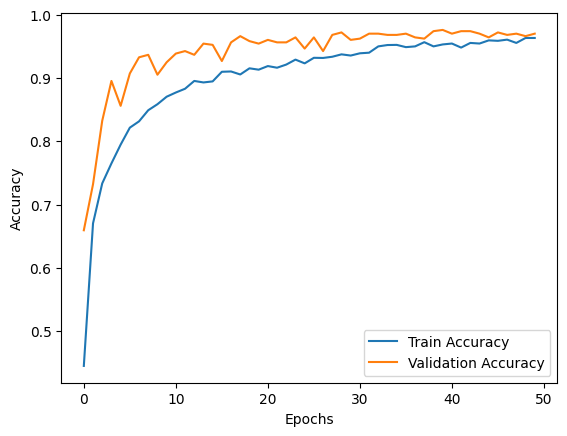

In [17]:
import matplotlib.pyplot as plt

# Plot the training history
plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy')
plt.plot(history_fine_tune.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

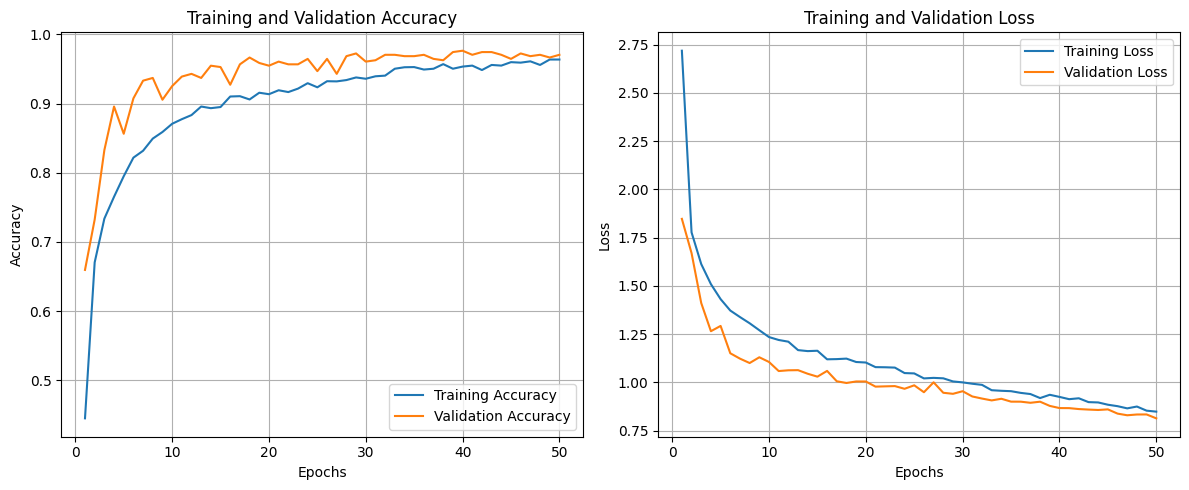

In [18]:
epochs = range(1, len(history_fine_tune.history['accuracy']) + 1)
train_accuracy = history_fine_tune.history['accuracy']
val_accuracy = history_fine_tune.history['val_accuracy']
train_loss = history_fine_tune.history['loss']
val_loss = history_fine_tune.history['val_loss']

# Plotting accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

In [19]:
test_loss, test_accuracy = ensemble_model.evaluate(test_generator)
print(f"Test accuracy: {test_accuracy:.4f}, Test loss: {test_loss:.4f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.9762 - loss: 0.8078
Test accuracy: 0.9843, Test loss: 0.7903


In [20]:
from sklearn.metrics import classification_report

# Get predictions
y_pred = ensemble_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
y_test_numeric = np.array([int(label) for label in y_test])

# Print classification report
print(classification_report(y_test_numeric, y_pred_classes))

20/20 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       330
           1       0.98      0.95      0.97       126
           2       0.99      0.99      0.99       124
           3       1.00      1.00      1.00        55

    accuracy                           0.98       635
   macro avg       0.99      0.98      0.99       635
weighted avg       0.98      0.98      0.98       635



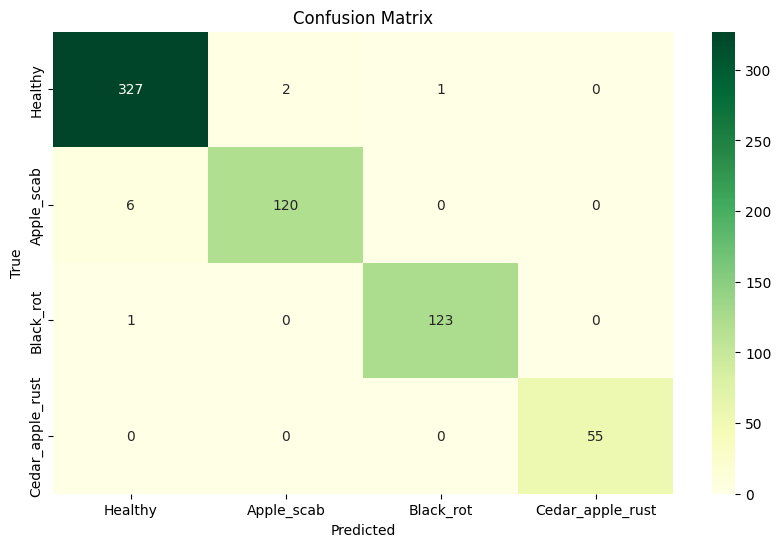

                  precision    recall  f1-score   support

         Healthy       0.98      0.99      0.98       330
      Apple_scab       0.98      0.95      0.97       126
       Black_rot       0.99      0.99      0.99       124
Cedar_apple_rust       1.00      1.00      1.00        55

        accuracy                           0.98       635
       macro avg       0.99      0.98      0.99       635
    weighted avg       0.98      0.98      0.98       635



In [21]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define class names
class_names = [
    "Healthy",
    "Apple_scab",
    "Black_rot",
    "Cedar_apple_rust"
]

# Compute confusion matrix
cm = confusion_matrix(y_test_numeric, y_pred_classes)

# Visualize confusion matrix
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGn', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
report = classification_report(y_test_numeric, y_pred_classes, target_names=class_names)
print(report)